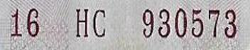

In [2]:
import os
import shutil
from PIL import Image
from IPython.display import display
for filename in os.listdir(r'C:\Users\32233\PycharmProjects\temp\boxeswithoutall\valid'):
    img = Image.open(os.path.join(r'C:\Users\32233\PycharmProjects\temp\boxeswithoutall\valid',filename))
    img = img.resize((250,50))
    display(img)
    break

In [1]:
from __future__ import print_function
from __future__ import division

import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import os
import utils
import dataset

import RCNN as crnn

parser = argparse.ArgumentParser()
parser.add_argument('--trainRoot', required=True, help='path to dataset')
parser.add_argument('--valRoot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imgH', type=int, default=32, help='the height of the input image to network')
parser.add_argument('--imgW', type=int, default=100, help='the width of the input image to network')
parser.add_argument('--nh', type=int, default=256, help='size of the lstm hidden state')
parser.add_argument('--nepoch', type=int, default=25, help='number of epochs to train for')
# TODO(meijieru): epoch -> iter
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--pretrained', default='', help="path to pretrained model (to continue training)")
parser.add_argument('--alphabet', type=str, default='0123456789abcdefghijklmnopqrstuvwxyz')
parser.add_argument('--expr_dir', default='expr', help='Where to store samples and models')
parser.add_argument('--displayInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--n_test_disp', type=int, default=10, help='Number of samples to display when test')
parser.add_argument('--valInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--saveInterval', type=int, default=500, help='Interval to be displayed')
parser.add_argument('--lr', type=float, default=0.01, help='learning rate for Critic, not used by adadealta')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--adam', action='store_true', help='Whether to use adam (default is rmsprop)')
parser.add_argument('--adadelta', action='store_true', help='Whether to use adadelta (default is rmsprop)')
parser.add_argument('--keep_ratio', action='store_true', help='whether to keep ratio for image resize')
parser.add_argument('--manualSeed', type=int, default=1234, help='reproduce experiemnt')
parser.add_argument('--random_sample', action='store_true', help='whether to sample the dataset with random sampler')
opt = parser.parse_args()
print(opt)

if not os.path.exists(opt.expr_dir):
    os.makedirs(opt.expr_dir)

random.seed(opt.manualSeed)
np.random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

train_dataset = dataset.lmdbDataset(root=opt.trainroot)
assert train_dataset
if not opt.random_sample:
    sampler = dataset.randomSequentialSampler(train_dataset, opt.batchSize)
else:
    sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=opt.batchSize,
    shuffle=True, sampler=sampler,
    num_workers=int(opt.workers),
    collate_fn=dataset.alignCollate(imgH=opt.imgH, imgW=opt.imgW, keep_ratio=opt.keep_ratio))
test_dataset = dataset.lmdbDataset(
    root=opt.valroot, transform=dataset.resizeNormalize((100, 32)))

nclass = len(opt.alphabet) + 1
nc = 1

converter = utils.strLabelConverter(opt.alphabet)
criterion = CTCLoss()


# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


crnn = crnn.CRNN(opt.imgH, nc, nclass, opt.nh)
crnn.apply(weights_init)
if opt.pretrained != '':
    print('loading pretrained model from %s' % opt.pretrained)
    crnn.load_state_dict(torch.load(opt.pretrained))
print(crnn)

image = torch.FloatTensor(opt.batchSize, 3, opt.imgH, opt.imgH)
text = torch.IntTensor(opt.batchSize * 5)
length = torch.IntTensor(opt.batchSize)

if opt.cuda:
    crnn.cuda()
    crnn = torch.nn.DataParallel(crnn, device_ids=range(opt.ngpu))
    image = image.cuda()
    criterion = criterion.cuda()

image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager
loss_avg = utils.averager()

# setup optimizer
if opt.adam:
    optimizer = optim.Adam(crnn.parameters(), lr=opt.lr,
                           betas=(opt.beta1, 0.999))
elif opt.adadelta:
    optimizer = optim.Adadelta(crnn.parameters())
else:
    optimizer = optim.RMSprop(crnn.parameters(), lr=opt.lr)


def val(net, dataset, criterion, max_iter=100):
    print('Start val')

    for p in crnn.parameters():
        p.requires_grad = False

    net.eval()
    data_loader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=opt.batchSize, num_workers=int(opt.workers))
    val_iter = iter(data_loader)

    i = 0
    n_correct = 0
    loss_avg = utils.averager()

    max_iter = min(max_iter, len(data_loader))
    for i in range(max_iter):
        data = val_iter.next()
        i += 1
        cpu_images, cpu_texts = data
        batch_size = cpu_images.size(0)
        utils.loadData(image, cpu_images)
        t, l = converter.encode(cpu_texts)
        utils.loadData(text, t)
        utils.loadData(length, l)

        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        cost = criterion(preds, text, preds_size, length) / batch_size
        loss_avg.add(cost)

        _, preds = preds.max(2)
        preds = preds.squeeze(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(preds.data, preds_size.data, raw=False)
        for pred, target in zip(sim_preds, cpu_texts):
            if pred == target.lower():
                n_correct += 1

    raw_preds = converter.decode(preds.data, preds_size.data, raw=True)[:opt.n_test_disp]
    for raw_pred, pred, gt in zip(raw_preds, sim_preds, cpu_texts):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt))

    accuracy = n_correct / float(max_iter * opt.batchSize)
    print('Test loss: %f, accuray: %f' % (loss_avg.val(), accuracy))


def trainBatch(net, criterion, optimizer):
    data = train_iter.next()
    cpu_images, cpu_texts = data
    batch_size = cpu_images.size(0)
    utils.loadData(image, cpu_images)
    t, l = converter.encode(cpu_texts)
    utils.loadData(text, t)
    utils.loadData(length, l)

    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    cost = criterion(preds, text, preds_size, length) / batch_size
    crnn.zero_grad()
    cost.backward()
    optimizer.step()
    return cost


for epoch in range(opt.nepoch):
    train_iter = iter(train_loader)
    i = 0
    while i < len(train_loader):
        for p in crnn.parameters():
            p.requires_grad = True
        crnn.train()

        cost = trainBatch(crnn, criterion, optimizer)
        loss_avg.add(cost)
        i += 1

        if i % opt.displayInterval == 0:
            print('[%d/%d][%d/%d] Loss: %f' %
                  (epoch, opt.nepoch, i, len(train_loader), loss_avg.val()))
            loss_avg.reset()

        if i % opt.valInterval == 0:
            val(crnn, test_dataset, criterion)

        # do checkpointing
        if i % opt.saveInterval == 0:
            torch.save(
                crnn.state_dict(), '{0}/netCRNN_{1}_{2}.pth'.format(opt.expr_dir, epoch, i))

ModuleNotFoundError: No module named 'lmdb'